# `pylibs` Test 1

In [1]:
import numpy as np
from pylibs.plasma import plasma
from pylibs.analysis import boltzmann, optimizePlasma

from test1 import loadlines, levels # test functions to load lines and levels data

import matplotlib.pyplot as plt
plt.style.use( 'ggplot' )

## A Test Plasma: Copper - Tin 

In [2]:
# copper - tin element data tree

lines = loadlines("percistent_lines.txt", ['cu', 'sn'] )

etree = {
            'cu': {
                    'm'      : 63.546,
                    'species': [
                                    {
                                        'Vs'    : 7.726380,
                                        'levels': levels('cu-1'),
                                        'lines' : lines,
                                    },
                                    {
                                        'Vs'    : 20.29239,
                                        'levels': levels('cu-2'),
                                        'lines' : lines,
                                    },
                            ]
                },
            'sn': {
                    'm'      : 118.710,
                    'species': [
                                    {
                                        'Vs'    : 7.343918,
                                        'levels': levels('sn-1'),
                                        'lines' : lines,
                                    },
                                    {
                                        'Vs'    : 14.63307,
                                        'levels': levels('sn-2'),
                                        'lines' : lines,
                                    }
                            ]
                },
        }

c = { 'cu': 'tab:blue', 'sn': 'green', }

copper_tin = plasma('copper_tin', etree)

a = copper_tin(70.0)  # copper and tin in 70:30 ratio

a.setup(1.0, 1.0E+17) # set up the plasma at Te = 1 eV and Ne = 1E+17 /cc

a.lock() # lock plasma to protect data

## Getting Plasma Conditions Back

In [3]:
lnt = a.lines          # line table

b   = copper_tin(50.0) # plasma setup at guess conditions 
b.setup(0.5, 1.0E+17)
b.lock()

optimizePlasma( lnt, b )

print(
            "optimum: Te = {0:.3f} eV, conc.: copper = {1:.3f}, tin = {2:.3f}".format(
               b.Te, 
               b.composition['cu'],
               b.composition['sn']
          )
     )

print(
            "exact  : Te = {0:.3f} eV, conc.: copper = {1:.3f}, tin = {2:.3f}".format(
               a.Te, 
               a.composition['cu'],
               a.composition['sn']
          )
     )

boltzmann(lnt, 2, b)  # get boltzmann plot coordinates (optimum)

optimum: Te = 1.000 eV, conc.: copper = 70.000, tin = 30.000
exact  : Te = 1.000 eV, conc.: copper = 70.000, tin = 30.000


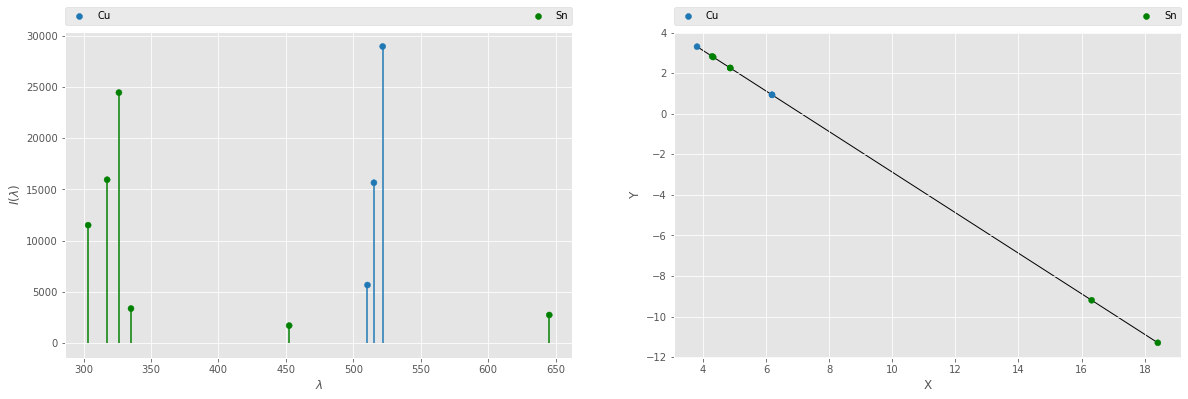

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 6])

ax1.scatter( lnt.wavelen, lnt.I, c = np.array([ c[x] for x in lnt.elem ]) )
ax1.vlines( lnt.wavelen, 0.0, lnt.I, colors = np.array([ c[x] for x in lnt.elem ]) )
ax1.scatter([], [], c = c['cu'], label = 'Cu')
ax1.scatter([], [], c = c['sn'], label = 'Sn')

ax1.legend(
                bbox_to_anchor = (0.0, 1.02, 1.0, 0.102),
                loc = 'lower left', ncol = 2,
                mode = 'expand', borderaxespad = 0,
          )
ax1.set( xlabel = '$\\lambda$', ylabel = '$I(\\lambda)$' )

ax2.scatter( lnt.boltzX, lnt.boltzY , c = np.array([ c[x] for x in lnt.elem ]) )

i = np.argsort( lnt.boltzX )
ax2.plot( lnt.boltzX[i], lnt.boltzY[i] , color = 'black', lw = 1, zorder = 0 )

ax2.scatter([], [], c = c['cu'], label = 'Cu')
ax2.scatter([], [], c = c['sn'], label = 'Sn')

ax2.legend(
                bbox_to_anchor = (0.0, 1.02, 1.0, 0.102),
                loc = 'lower left', ncol = 2,
                mode = 'expand', borderaxespad = 0,
          )
ax2.set( xlabel = 'X', ylabel = 'Y' )

plt.show()

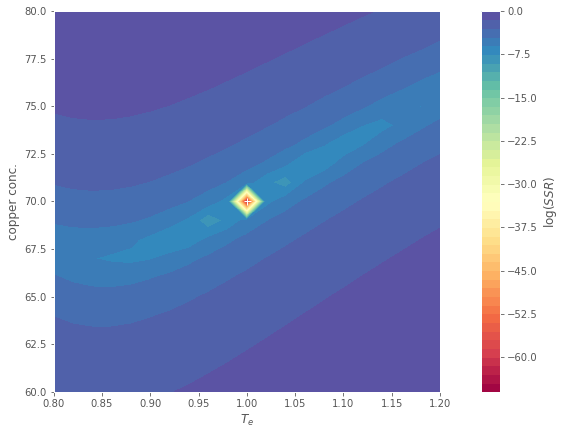

In [14]:
def boltzspread(lnt, tvec, cvec, ne, p0):
    """ rms spred in boltzmann polot points from a line.  """
    tvec, cvec = np.asfarray(tvec), np.asfarray(cvec)
    
    from pylibs.analysis import boltzmannXY

    t, c = np.meshgrid( tvec, cvec )

    p = copper_tin(p0.cu)
    p.lock()

    def f(ti, ci):
        p.setComposition(ci)
        p.setup(ti, ne)
        x, y = boltzmannXY( lnt, 2, None, p )
        m, c = np.polyfit( x, y, deg = 1 )
        return np.sum( ( y - ( m*x+c ) )**2 )

    y = np.asfarray( 
                        list( 
                                map( f, t.flatten(), c.flatten() ) 
                            ) 
                   ).reshape( t.shape )

    fig, (ax, cax) = plt.subplots( 1, 2, figsize = [8,7], gridspec_kw = {'width_ratios': [1, 0.05]} ) 

    clr = ax.contourf(t, c, np.log(y), levels = 51, cmap = 'Spectral')

    ax.plot( p0.Te, p0.cu, '+', ms = 7, color = 'white' )

    ax.set(xlabel = '$T_e$', ylabel = 'copper conc.')

    plt.colorbar(clr, cax)
    cax.set_ylabel('$\\log(SSR)$')

    plt.show()


boltzspread( lnt, np.mgrid[0.8:1.2:21j], np.mgrid[60:80:21j], 1.0E+17, a )